In [1]:
import numpy as np
from numpy.random import normal,uniform
import matplotlib.pyplot as plt
from scipy import stats


def varsolution(x0,x1,s0=1.0,s1=1.0):
    num = (x0/(s0*s0)) + (x1/(s1*s1))
    den = (1.0/(s0*s0)) + (1.0/(s1*s1))
    return num/den,np.sqrt(1./den)


def setbounds(post,li,pr):
    signal = np.where(post>post.max()/500)[0]
    minx,maxx=x[signal.min()],x[signal.max()]
    signal = np.where(li>li.max()/500)[0]
    minx,maxx=min(minx,x[signal.min()]),max(maxx,x[signal.max()])
    signal = np.where(pr>pr.max()/500)[0]
    minx,maxx=min(minx,x[signal.min()]),max(maxx,x[signal.max()])
    plt.xlim(minx,maxx)

# Application of Bayes Theorum to estimation

Bayes theorum is:

$$
P(x|y) = \frac{P(y|x) P(x)}{P(y)}
$$

We can interpret $P(x)$ as the Prior PDF of state $x$ and $P(x|y)$ and the Posterior PDF of $x$, given some new measurement $y$. $P(y|x)$ can be seen as the Likelihood $\mathcal{L}(y|x)$ of the observation $y$ given state $x$. 

The *marginal* $P(y) = \Sigma_{x \in \mathcal{X}} P(y|x) P(x)$ is a normalisation term with $\mathcal{X}$ the set of all possible values of $x$. Ignoring the normalisation term, we can state:

$$
P(x|y) \propto P(y|x) P(x)
$$

We may have some observation operator $\hat{y}=H(x) + \epsilon$ that relates state to observation.

But to start with, assume $\hat{y}=x + \epsilon$, with $\epsilon$ zero-mean Gaussian so the PDF $P(y|x)$ is defined by some mean $\overline{y}$ and standard deviation $\sigma_y$. Assume that the prior (background) is also Gaussian.

In [2]:
"""xobs = 3.
sigmaobs = 2.0
xb = 0
sigmab = 1.0"""

# observation
xobs = 3.
sigmaobs = 0.7

# prior
xb = 0
sigmab = 2.0

# Define the Likelihood P(y|x) 
# the probability that the observation is y, given parameter value x
def likelihood(p,mean=0.,std=1.0):
    z = (p-mean)/std
    return stats.norm.pdf(z)

# Define Prior Function - P(x)
def prior(p,mean=0.,std=1.0):
    z = (p-mean)/std
    return stats.norm.pdf(z)

mean 2.67 sd 0.661


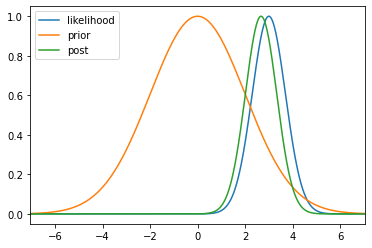

In [3]:
# want posterior P(x|y) 
# where y is our 'observation'
# and x is some value of our parameter we are trying to estimate

# P(x|y)  = P(y|x) P(x) / P(y)
# we can simply calculate 
# P(x|y)  = P(y|x) P(x) and rescale

# sample over x
x = np.arange(-10,10,.01)
li = likelihood(x,xobs,sigmaobs)
pr = prior(x,xb,sigmab) 

# Bayes rule
post = li * pr

plt.plot(x,li/li.max(),label='likelihood')
plt.plot(x,pr/pr.max(),label='prior')
plt.plot(x,post/post.max(),label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')

The posterior lies between the prior and the likelihood, and is essentially a weighted average of the two. 

If we add another observation, we can again update the distribution:

mean 2.67 sd 0.661
mean 2.83 sd 0.480


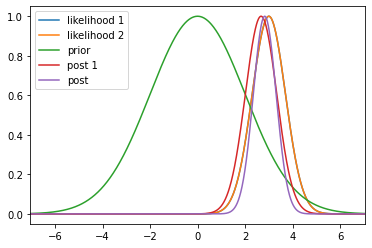

In [4]:
# observation
xobs2 = 3.
sigmaobs2 = 0.7

li1 = likelihood(x,xobs,sigmaobs)
li2 = likelihood(x,xobs2,sigmaobs2)
pr = prior(x,xb,sigmab) 

# Bayes rule
post1 = li1 * pr
post = post1 * li2

plt.plot(x,li1/li1.max(),label='likelihood 1')
plt.plot(x,li2/li2.max(),label='likelihood 2')
plt.plot(x,pr/pr.max(),label='prior')
plt.plot(x,post1/post1.max(),label='post 1')
plt.plot(x,post/post.max(),label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post1*x)/np.mean(post1)
var = np.nansum(post1*(x-mean)**2)/np.nansum(post1)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')
mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')

Which of course we could have done in one step:

mean 2.83 sd 0.480


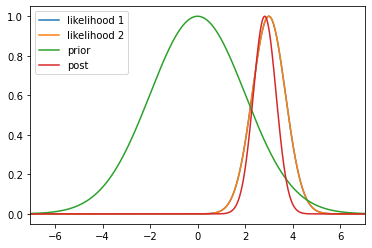

In [5]:
li1 = likelihood(x,xobs,sigmaobs)
li2 = likelihood(x,xobs2,sigmaobs2)
pr = prior(x,xb,sigmab) 

# Bayes rule
post = li1 * pr * li2

plt.plot(x,li1/li1.max(),label='likelihood 1')
plt.plot(x,li2/li2.max(),label='likelihood 2')
plt.plot(x,pr/pr.max(),label='prior')
plt.plot(x,post/post.max(),label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')

Because these are Gaussian PDFs of the form $\text{exp}(-\mathcal{J_y})$ with $\mathcal{J_{y_i}} = \frac{1}{2} (x-\overline{y_i})^TC_{y_i}^{-1}(x-\overline{y_i})$, we use the negative log likelihood:

$$
\mathcal{J} = \Sigma_i \mathcal{J_{y_i}} + \mathcal{J_{b}}
$$

with $\mathcal{J_{b}}$ the negative log prior and $\mathcal{J_{y_i}}$ the negative log likelihood of the observations. For univariate $x$ this is:

$$
\mathcal{J} = \frac{1}{2} \sum_i{\frac{(x-\overline{y_i})^2}{\sigma_{y_i}^2}} + \frac{1}{2} \frac{(x-\overline{x_b})^2}{\sigma_{x_b}^2}
$$

for measurements $\mathcal{N}(\overline{y_i},\sigma_{y_i}^2)$ and prior $\mathcal{N}(\overline{x_b},\sigma_{x_b}^2)$ .

Then the posterior mean is found by minimising $\mathcal{J}$ wrt $x$, and the uncertainty in $x$ from the curvature of $J$. So the posterior mean and variance are:


$$
x=\frac{ \sum_i{\frac{\overline{y_i}}{σ_{y_i}^2}} + \frac{x_b}{σ_{x_b}^2}}{\sum_i{\frac{1}{σ_{y_i}^2}} + \frac{1}{σ_{x_b}^2}}
$$


$$
\sigma^2=\frac{ 1}{\sum_i{\frac{1}{σ_{y_i}^2}} + \frac{1}{σ_{x_b}^2}}
$$




The mean is just a reciprocal-uncertainty weighted average. 

In [6]:
mean,std = varsolution(xobs,xb,sigmaobs,sigmab)
print(f'mean {mean:.2f} sd {std:.3f}')

# observation 2
xobs2 = 3.
sigmaobs2 = 0.7
# 2nd obs
mean,std = varsolution(xobs2,mean,sigmaobs2,std)
print(f'mean {mean:.2f} sd {std:.3f}')

mean 2.67 sd 0.661
mean 2.83 sd 0.480


# Monte Carlo 

When you do this over multiple dimensions and still keep the flexibility of not having to use only Gaussian distributions, you'll want to calculate those summations (integrals) over random samples (Monte Carlo Methods). So lets just show how that works for a univariate case as above. First, let's sample over $x$:


mean 2.76 sd 0.544


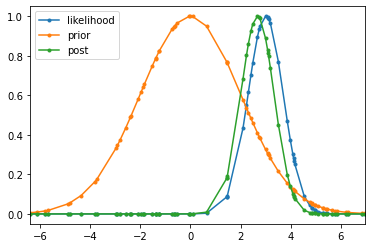

In [7]:
# lets sample over the x on a flat distribution
# with a large number of samples
# the fewer the samples, the more noise in the mean 
# BUT especially the std estimate

# number of samples
N = 100

# random over x
# we only sort to make the plotting easier
x = np.sort(uniform(-10,10,N))

li = likelihood(x,xobs,sigmaobs)
pr = prior(x,xb,sigmab) 

# Bayes rule
post = li * pr

plt.plot(x,li/li.max(),'.-',label='likelihood')
plt.plot(x,pr/pr.max(),'.-',label='prior')
plt.plot(x,post/post.max(),'.-',label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')

That works ok, and is just a straight MC method for the integrals. We can improve on it by increasing the number of samples. The error should broadly decrease with $1/\sqrt N$.



mean 2.67 sd 0.661


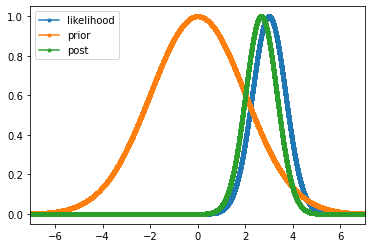

In [8]:
# number of samples
# mean 1.78 sd 0.661
N = 100000

# random over x
# we only sort to make the plotting easier
x = np.sort(uniform(-10,10,N))

li = likelihood(x,xobs,sigmaobs)
pr = prior(x,xb,sigmab) 

# Bayes rule
post = li * pr

plt.plot(x,li/li.max(),'.-',label='likelihood')
plt.plot(x,pr/pr.max(),'.-',label='prior')
plt.plot(x,post/post.max(),'.-',label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')

But it is inefficient as it doesn't take account of anything we know about the distributions. The uncertainty estimate can need a *lot* of samples.


# Importance sampling

We can improve on efficiency by biasing the sampling, e.g. sampling over the prior, using something called importance sampling, then taking account of that when we calculate the integrals. The danger is that we might not sample the likelihood well, so we need to be aware of that, and do some tests (not done here). But in any case, we can see above that we do not sample the likelihood well.

mean 2.52 sd 0.664


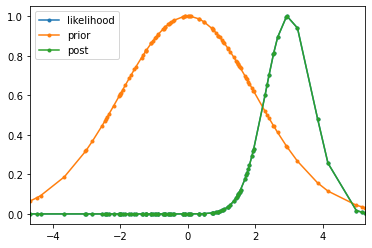

In [9]:
# lets sample over the x on the prior
# with a large number of samples
# the fewer the samples, the more noise in the mean 
# BUT especially the std estimate

# number of samples
N = 100

# random over prior now
# we only sort to make the plotting easier
x = np.sort(normal(xb,sigmab,N))

li = likelihood(x,xobs,sigmaobs)
# account for the fact that we have sampled this already
# so this takes the prior out of the equation
pr = prior(x,xb,sigmab)/prior(x,xb,sigmab)

# Bayes rule
post = li * pr

plt.plot(x,li/li.max(),'.-',label='likelihood')
plt.plot(x,prior(x,xb,sigmab)/prior(x,xb,sigmab).max(),'.-',label='prior')
plt.plot(x,post/post.max(),'.-',label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')

We now have more samples in the middle of the prior than we had in the uniform distribution. The estimate is slightly more efficient now, but that depends how far away the observation is from the prior.

Let's increase the sample number:

mean 2.66 sd 0.649


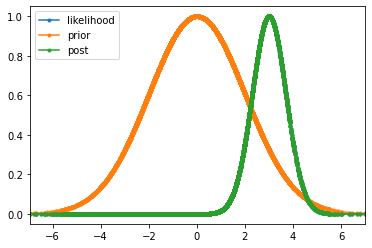

In [10]:
# lets sample over the x on the prior
# with a large number of samples
# the fewer the samples, the more noise in the mean 
# BUT especially the std estimate

# number of samples
N = 10000

def likelihood(p,mean=0.,std=1.0):
    z = (p-mean)/std
    return stats.norm.pdf(z)

def prior(p,mean=0.,std=1.0):
    z = (p-mean)/std
    return stats.norm.pdf(z)

# random over prior now
# we only sort to make the plotting easier
x = np.sort(normal(xb,sigmab,N))

# for plotting
pr = prior(x,xb,sigmab)

li = likelihood(x,xobs,sigmaobs)
# account for the fact that we have sampled this already
# so this takes the prior out of the equation

# Bayes rule
post = li 

plt.plot(x,li/li.max(),'.-',label='likelihood')
plt.plot(x,prior(x,xb,sigmab)/prior(x,xb,sigmab).max(),'.-',label='prior')
plt.plot(x,post/post.max(),'.-',label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')

# Rejection

If we sample over the prior, and know that the likelihood of any sample state is very low, we can reasonably reject those samples. We can then choose to just proceed with the unrejected samples, or we can keep generating samples until we get a good number that we don't reject. If we had some simple way of getting a better sampling scheme, then would could use that, but a simple rejection approach may often be useful, provided we have a fast way to reject unwanted samples.

312 1000 1
997 1000 2
mean 2.73 sd 0.639


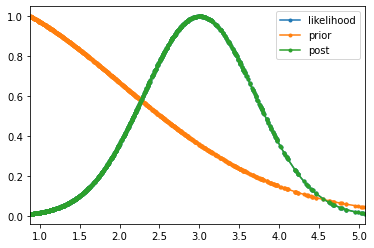

In [11]:
# lets sample over the x on the approximation of the posterior 
# with a large number of samples
# the fewer the samples, the more noise in the mean 
# BUT especially the std estimate

# number of samples
N = 1000

def rejection(xb,sigmab,xobs,sigmaobs,N,fn=normal,s=0.01):
    # reject samples we dont want 
    # and generate a fuller set that we do
    scale = 1
    Nfound = 0
    saveset = np.array([])
    
    while (Nfound < N):
        x = fn(xb,sigmab,N*scale)
        # filter on likelihood
        li = likelihood(x,xobs,sigmaobs)
        li = li/li.max()
        # rejection of normalised li > 0.01
        x = x[li>s]
        Nfound = len(x) + len(saveset)
        if Nfound < N:
            print(Nfound,N,scale)
            scale *= 2
        saveset = np.append(saveset,x)
    x = np.sort(saveset[:N])
    return x

x = rejection(xb,sigmab,xobs,sigmaobs,N,s=0.01)
        
# for plotting
pr = prior(x,xb,sigmab)

li = likelihood(x,xobs,sigmaobs)
# account for the fact that we have sampled this already
# so this takes the prior out of the equation
pr = prior(x,xb,sigmab)

# Bayes rule on prior-biased sample set
post = li 

plt.plot(x,li/li.max(),'.-',label='likelihood')
plt.plot(x,prior(x,xb,sigmab)/prior(x,xb,sigmab).max(),'.-',label='prior')
plt.plot(x,post/post.max(),'.-',label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')
# mean 2.67 sd 0.661

# Potential problems with over-rejection

If you get too fussy in rejecting samples, you can introduce unwanted biases in the results.

The filtering above is probably fine because we have the uncertainty from the small sample number is dominating the result over any impact that likelihood values of less than 1\% have in this case (you can test this).

But, if you set that threshold too high, e.g. 0.5, you are liable to introduce a bias in the results because you are no longer sampling some significant part of the PDF:

128 1000 1
358 1000 2
818 1000 4
mean 2.87 sd 0.422


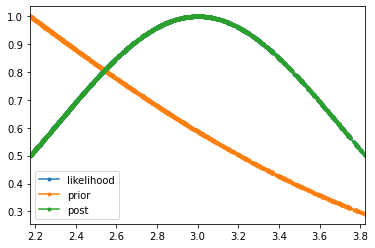

In [12]:
# number of samples
N = 1000

x = rejection(xb,sigmab,xobs,sigmaobs,N,s=0.5)
        
# for plotting
pr = prior(x,xb,sigmab)

li = likelihood(x,xobs,sigmaobs)
# account for the fact that we have sampled this already
# so this takes the prior out of the equation
pr = prior(x,xb,sigmab)

# Bayes rule on prior-biased sample set
post = li 

plt.plot(x,li/li.max(),'.-',label='likelihood')
plt.plot(x,prior(x,xb,sigmab)/prior(x,xb,sigmab).max(),'.-',label='prior')
plt.plot(x,post/post.max(),'.-',label='post')
plt.legend(loc='best')
setbounds(post,li,pr)

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')
# mean 2.67 sd 0.661

You will find that the higher the value of $s$ you use in rejection, even for the same number of samples, the more you will bias the mean posterior towards the mean likelihood, and away from the true posterior.

It is not a good idea to do this. You should be able to see that the same sort of effect would appear if you select only the top few samples that have highest likelihood. Again, that is not a good strategy.



You might argue that this is less important if you have a uniform prior. So let's try that. Let's have no rejection, and a large number of samples to establish the *true* posterior:

In [13]:
# number of samples
N = 1000000

# uniform prior, no rejection
x = rejection(xb-1.5*sigmab,xb+1.5*sigmab,xobs,sigmaobs,N,s=0.0,fn=uniform)
        
# for plotting
pr = prior(x,xb,sigmab)

li = likelihood(x,xobs,sigmaobs)
# account for the fact that we have sampled this already
# so this takes the prior out of the equation
pr = prior(x,xb,sigmab)

# Bayes rule on prior-biased sample set
post = li 

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')
# mean 2.44 sd 0.422

mean 2.44 sd 0.422


And now, let's reject samples that are away from the likelihood:

In [14]:
# number of samples
N = 1000000

# uniform prior, no rejection
x = rejection(xb-1.5*sigmab,xb+1.5*sigmab,xobs,sigmaobs,N,s=0.05,fn=uniform)
        
# for plotting
pr = prior(x,xb,sigmab)

li = likelihood(x,xobs,sigmaobs)
# account for the fact that we have sampled this already
# so this takes the prior out of the equation
pr = prior(x,xb,sigmab)

# Bayes rule on prior-biased sample set
post = li 

mean = np.mean(post*x)/np.mean(post)
var = np.nansum(post*(x-mean)**2)/np.nansum(post)
print(f'mean {mean:.2f} sd {np.sqrt(var):.3f}')
# mean 2.44 sd 0.422

285002 1000000 1
856079 1000000 2
mean 2.46 sd 0.389


With this large sample number (low uncertainty in the mean), the rejection starts to impact the last s.d. even at the $s=0.05$ level. By the time we reject at $s=0.5$, we are more clearly seeing the bias. The size of the bias will depend on the weighted distance between the prior and observation, so might not be something you always have under control in an experiment. 

# Uniform prior and likelihood

What if the likelihood is uniform then? In that case, the likelihood samples take on values of 0 or 1, so a sample is or out when the likelihood is applied. In that case, there is no influence from rejecting samples that would have a likelihood of 0.

But you have to ask if that is likely a good representation of observation uncertainty. You can argue that a Gaussian to too peaky, or not peaky enough for what you suspect the observation uncertainties to be, and that is a debate to have. Change of shape in the distributions will mostly have only a small influence, provided they all tail off around the same point, and the general width of the distribution will be more important. That is less true for a uniform distribution that terminates suddenly. In engineering, we would say that these have bad frequency response: the result will be much more sensitive to exactly what value of distribution width you define. If there is no reason to impose that, then don't.


# Discussion

When we develop an MC scheme where we sample over a prior, we can apply simple rules for rejecting samples that would have a low likelihood. This can be very attractive if we have fast methods for assessing low likelihood.

Where there are multiple samples / observations, the likelihoods are multiplied, so if some parameter $x$ produces a low likelihood for any sample, that can be sufficient reason for rejection. That is another attractive feature for an EnVar-type approach, though we obviously need to be careful about outlier rejection, where we effectively choose to reject the outlier rather than the Ensemble sample. For robust methods, we might prefer likelihoods shaped like a Huber Norm, so that they have L1 behaviour within some limits, and L2 beyond that.

We have seen that over-rejection of ensemble samples can lead to bias (away from the prior and towards the likelihood). This is the case whether the prior is Gaussian or uniform. If there are a large number of samples, this may not be too important as the prior information will become replaced by that of the observations. But if, we we often are, we are more sample- or information-limited, this would effectively weaken the prior's influence in the posterior. If we had intended that, we should probably define a weaker prior, rather than let bias creep in like this. 

We note that, if we assume uniform distributions for likelihoods, then a simple 'unweighted' approach can be taken to calculation of sample means and width. But this is very different to how we would normally characterise observation uncertainties, and the results are likely much more sensitive to how we characterise the (width of the) uncertainty for observations. Again, if there are a large number of observations, this is likely unimportant, but we should not design this into a scheme without some thought and testing.

# Conclusion

If we want to make estimates in a system of noisy observations, and if we have enough independent observations and enough information in them, we do not need to be concerned about the details of distributions or indeed an prior constraints. 

In the more usual case of under-constrained problems we deal with, we do need to be concerned with these, and should opt for conservative, reasonable choices e.g. in the PDFs we assume for observations and also in the use and strength of any prior.